Teste com utilização de projetor gama para identificar todas as estrelas na imagem

Uso de find_peaks para identificar os picos de luminosidade nas imagens

Proeminência de 1% do valor máximo

projetor gama = mapa de correlação resultante da iteração dos paramêtros Ks e desvio padrão dentro do espaço de pesquisa definido

- Imagem: 120x120

- Scale: 0.4

- Origem: skyserver dr18

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # OpenCV para carregar a imagem
from PIL import Image
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.signal import find_peaks
import matplotlib.image as mpimg

In [2]:
# Caminho para a imagem

# img_path = r"data\sdss\sdss_image_180.316130449752_-0.0240209645983516.jpg"
img_path = r"data\sdss\sdss_image_180.171408773627_0.35639930317447.jpg"


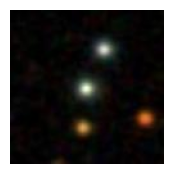

In [3]:
# Carregar a imagem
img_input = mpimg.imread(img_path)

# Criar uma nova figura
plt.figure(figsize=(2, 2))  # O argumento figsize define o tamanho da figura

# Exibir a imagem
plt.imshow(img_input)

# Remover os eixos (opcional)
plt.axis('off')

# Mostrar a figura
plt.show()

## Reader

In [4]:
# Abrir a imagem e converter para escala de cinza
reader_input = Image.open(img_path).convert('L')
reader_output = np.array(reader_input)

# Print da imagem em array
print(reader_output)


[[ 2  2  1 ...  5  8  9]
 [ 2  2  1 ...  6  8 10]
 [ 2  2  1 ...  6  9 10]
 ...
 [ 3  4  4 ...  4  5  5]
 [ 0  1  2 ...  6  6  6]
 [ 0  0  1 ...  7  7  6]]


## Preprocessing

In [5]:
# Preprocessamento: subtrair a média para suavizar
img_avg = reader_output - reader_output.mean()

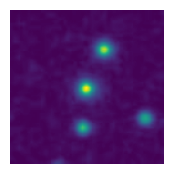

In [6]:
# Criar uma nova figura
plt.figure(figsize=(2, 2))  # O argumento figsize define o tamanho da figura

# Exibir a imagem
plt.imshow(img_avg)

# Remover os eixos (opcional)
plt.axis('off')

# Mostrar a figura
plt.show()

## Model

In [7]:
# Função para gerar o kernel gaussiano
def gaussian_kernel(KSize, sigma):
    kernel = np.zeros((KSize, KSize))
    center = KSize // 2
    for i in range(KSize):
        for j in range(KSize):
            kernel[i, j] = (1 / (2 * np.pi * sigma ** 2)) * \
                           np.exp(-((i - center) ** 2 + (j - center) ** 2) / (2 * sigma ** 2))
    return kernel

# Função para gerar o mapa de correlação
def correlation_map(image, KSize, sigma):
    kernel = gaussian_kernel(KSize, sigma)
    M, N = image.shape
    corr_map = np.zeros((M - KSize + 1, N - KSize + 1))
    for x in range(M - KSize + 1):
        for y in range(N - KSize + 1):
            region = image[x:x + KSize, y:y + KSize]
            corr_map[x, y] = np.sum(region * kernel)
    return corr_map

# Função para gerar o projetor gama
def gamma_projector(image):
    M, N = image.shape
    gamma_map = np.zeros((M, N))
    for K_s in range(3, min(M, N), 2):
        for sigma in range(1, int(2 * K_s + 3)):
            corr_map = correlation_map(image, K_s, sigma)
            padded_corr_map = np.pad(corr_map, ((K_s//2, K_s//2), (K_s//2, K_s//2)), mode='constant')
            gamma_map += padded_corr_map[:M, :N]
    return gamma_map


In [8]:
star_positions = gamma_projector(img_avg)

star_positions

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , -14.32954102, -15.22628446, ...,  -8.51988221,
         -5.20114021,   0.        ],
       [  0.        , -14.50383884, -43.3194813 , ..., -25.33045421,
         -5.3066391 ,   0.        ],
       ...,
       [  0.        , -11.70799032, -33.41094779, ..., -30.1121349 ,
         -9.67813205,   0.        ],
       [  0.        , -14.48542922, -13.45793258, ...,  -8.65063541,
         -8.30203976,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

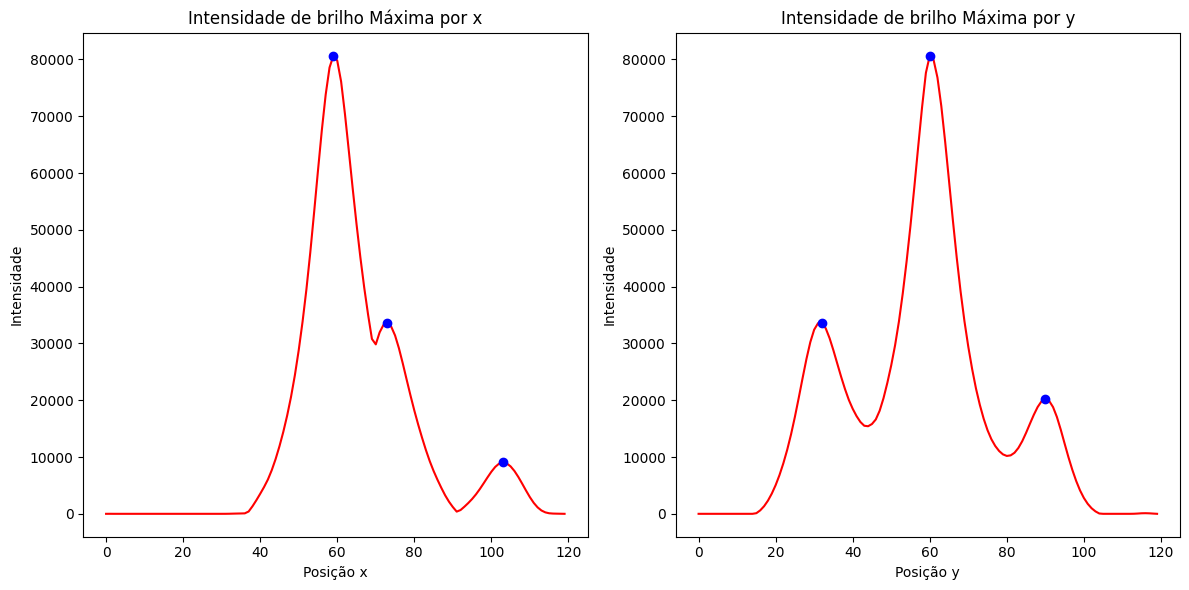

Pares de picos encontrados: [(59, 32), (59, 60), (59, 90), (73, 32), (73, 60), (103, 90)]


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Obter a intensidade ao longo das dimensões x e y
intensity = np.stack(star_positions, axis=0)

# Encontrar o maior valor ao longo da dimensão y para cada x
max_by_x = intensity.max(axis=0)  # Máximo ao longo da dimensão y

# Encontrar o maior valor ao longo da dimensão x para cada y
max_by_y = intensity.max(axis=1)  # Máximo ao longo da dimensão x

# Obter os valores de x e y
x_values = np.arange(intensity.shape[1])
y_values = np.arange(intensity.shape[0])

# Encontrar picos para a curva de intensidade por x
prominence_x = 0.01 * max(max_by_x)  # Proeminência de 1% do valor máximo observado
peaks_x, _ = find_peaks(max_by_x, prominence=prominence_x)

# Encontrar picos para a curva de intensidade por y
prominence_y = 0.01 * max(max_by_y)  # Proeminência de 1% do valor máximo observado
peaks_y, _ = find_peaks(max_by_y, prominence=prominence_y)

# Criar o gráfico
plt.figure(figsize=(12, 6))

# Plotar a curva de intensidade por x
plt.subplot(1, 2, 1)
plt.plot(x_values, max_by_x, color='red')
plt.plot(x_values[peaks_x], max_by_x[peaks_x], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por x')
plt.xlabel('Posição x')
plt.ylabel('Intensidade')

# Plotar a curva de intensidade por y
plt.subplot(1, 2, 2)
plt.plot(y_values, max_by_y, color='red')
plt.plot(y_values[peaks_y], max_by_y[peaks_y], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por y')
plt.xlabel('Posição y')
plt.ylabel('Intensidade')

plt.tight_layout()
plt.show()

# Verificar pares de picos potencialmente repetidos
pares_picos = []
for px in peaks_x:
    for py in peaks_y:
        if intensity[py, px] > prominence_y:  # Verifique se a intensidade no par é maior que o limiar
            pares_picos.append((x_values[px], y_values[py]))

# Exibir os pares de picos encontrados
print("Pares de picos encontrados:", pares_picos)


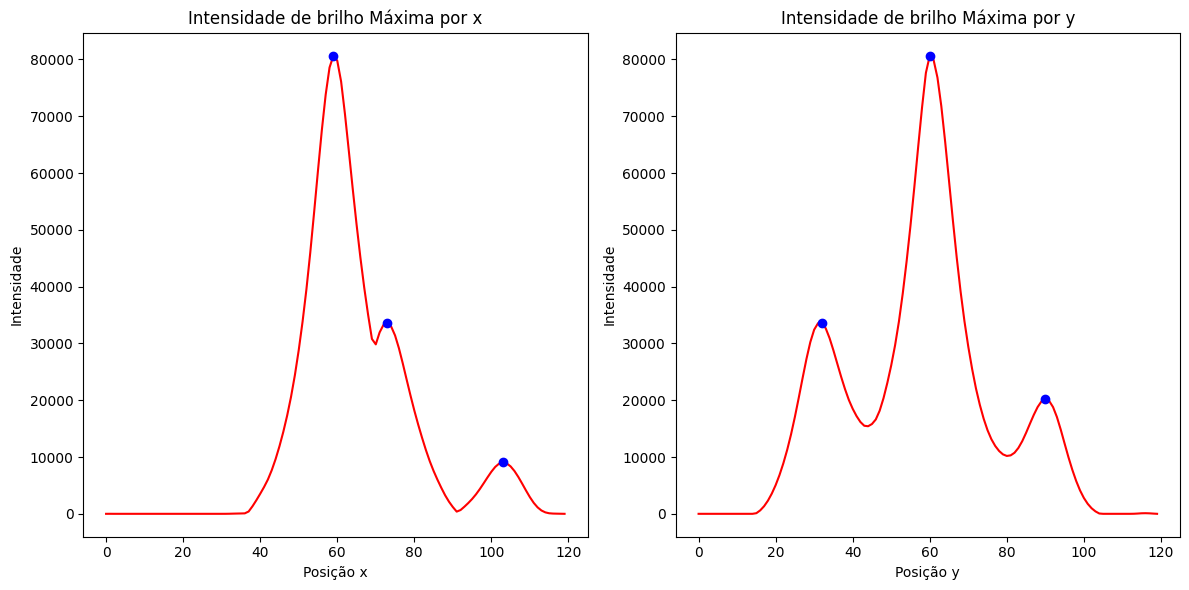

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Exemplo de matriz de intensidade simulada
intensity = np.stack(star_positions, axis=0)

# Encontrar o maior valor ao longo da dimensão y para cada x
max_by_x = intensity.max(axis=0)  # Máximo ao longo da dimensão y

# Encontrar o maior valor ao longo da dimensão x para cada y
max_by_y = intensity.max(axis=1)  # Máximo ao longo da dimensão x

# Obter os valores de x e y
x_values = np.arange(intensity.shape[1])
y_values = np.arange(intensity.shape[0])

# Encontrar picos para a curva de intensidade por x
prominence_x = 0.01 * max(max_by_x)  # Proeminência de 1% do valor máximo observado
peaks_x, _ = find_peaks(max_by_x, prominence=prominence_x)

# Encontrar picos para a curva de intensidade por y
prominence_y = 0.01 * max(max_by_y)  # Proeminência de 1% do valor máximo observado
peaks_y, _ = find_peaks(max_by_y, prominence=prominence_y)

# Criar o gráfico
plt.figure(figsize=(12, 6))

# Plotar a curva de intensidade por x
plt.subplot(1, 2, 1)
plt.plot(x_values, max_by_x, color='red')
plt.plot(x_values[peaks_x], max_by_x[peaks_x], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por x')
plt.xlabel('Posição x')
plt.ylabel('Intensidade')

# Plotar a curva de intensidade por y
plt.subplot(1, 2, 2)
plt.plot(y_values, max_by_y, color='red')
plt.plot(y_values[peaks_y], max_by_y[peaks_y], 'bo', label='Picos')
plt.title('Intensidade de brilho Máxima por y')
plt.xlabel('Posição y')
plt.ylabel('Intensidade')

plt.tight_layout()
plt.show()


In [11]:
# Verificar pares de picos validos
pares_picos = []
threshold = 0.9  # Limite de 90% do valor máximo para considerar como um ponto válido

# Combinação dos picos detectados nos eixos x e y
# Para cada pico em x, verificamos a intensidade máxima ao longo do eixo y correspondente
for px in peaks_x:
    for py in peaks_y:
        if intensity[py, px] >= threshold * max(max_by_x[px], max_by_y[py]):
            pares_picos.append((x_values[px], y_values[py]))
pares_picos

[(59, 60), (73, 32)]

## Results

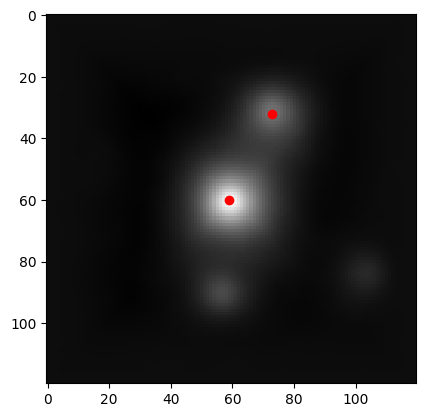

In [12]:
# Exemplo de visualização da imagem com os picos
plt.imshow(intensity, cmap='gray')
for (x, y) in pares_picos:
    plt.scatter([x], [y], color='red')
plt.show()

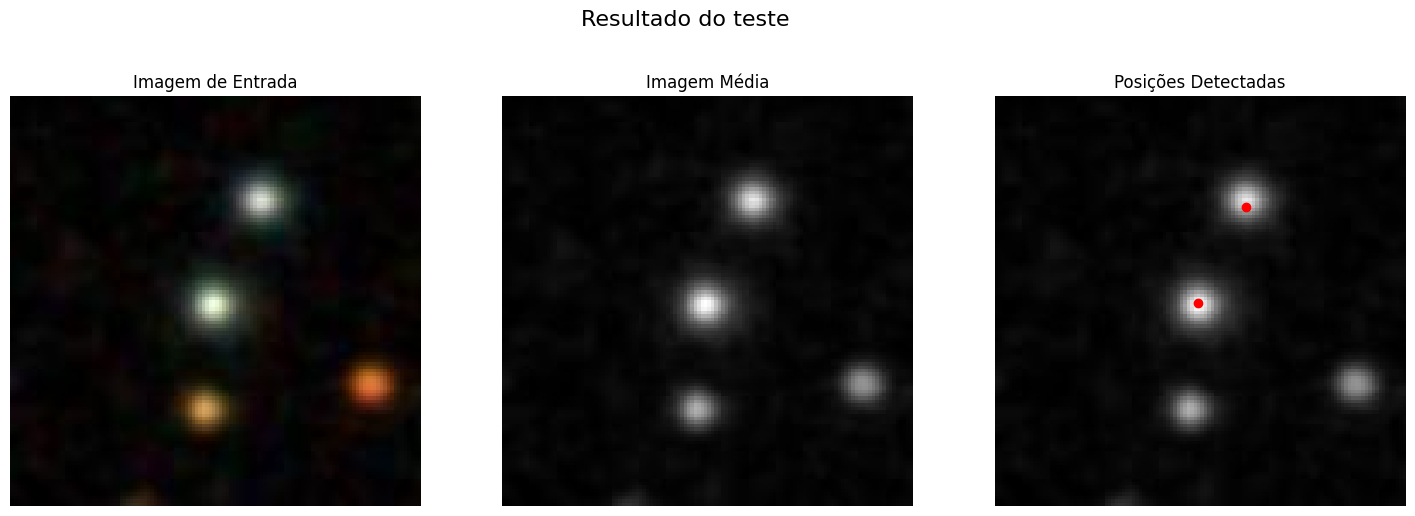

: 

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img_input, cmap='gray')
axes[0].set_title('Imagem de Entrada')
axes[0].axis('off')  # Remover os eixos

axes[1].imshow(img_avg, cmap='gray')
axes[1].set_title('Imagem Média')
axes[1].axis('off')

axes[2].imshow(img_avg, cmap='gray')
for (x, y) in pares_picos:
    axes[2].scatter([x], [y], color='red')
axes[2].set_title('Posições Detectadas')
axes[2].axis('off')

# Adicionar um título geral para a figura
fig.suptitle('Resultado do teste', fontsize=16)

plt.show()
